In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader 
from timm.utils import ModelEmaV3 #pip install timm 

import matplotlib.pyplot as plt #pip install matplotlib
import matplotlib.font_manager as font_manager
plt.rcParams["font.family"] = "serif"
plt.style.use('classic')
font = font_manager.FontProperties(family='serif', size=16)

import numpy as np
import math, os, random
from einops import rearrange #pip install einops
from typing import List

from pathlib import Path
from PIL import Image

import tqdm
from tqdm.notebook import tqdm #pip install tqdm

# Diffusion models for Galaxy images generation
______________
# Part 1: Designing the generative model

## Model design
Code source from <a href="https://towardsdatascience.com/diffusion-model-from-scratch-in-pytorch-ddpm-9d9760528946" target="_blank">Diffusion Model from Scratch in Pytorch</a> 

### UNET model
For our diffusion model we consider a architecture based on the <a href="https://arxiv.org/pdf/1505.04597" target="_blank"> UNET</a> model.

"The main idea is to supplement a usual contracting network by successive layers, where pooling operators are replaced by upsampling operators. Hence, these layers increase the resolution of the output. In order to localize, high resolution features from the contracting path are combined with the upsampled output. A successive convolution layer can then learn to assemble a more precise output based on this information"

*from "U-Net: Convolutional Networks for Biomedical Image Segmentation" (https://arxiv.org/pdf/1505.04597)*

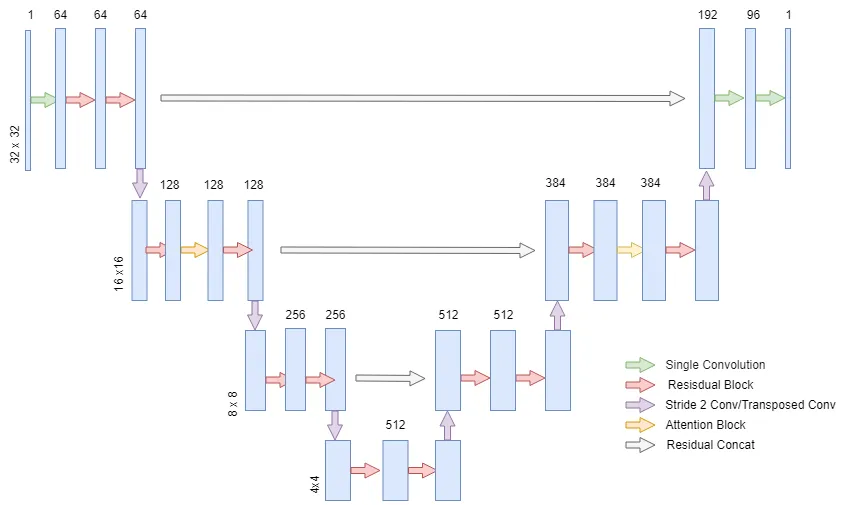

*by Nicholas DiSalvo in* <a href="https://towardsdatascience.com/diffusion-model-from-scratch-in-pytorch-ddpm-9d9760528946" target="_blank">*Diffusion Model from Scratch in Pytorch*</a> 

The U-net is composed of residual convolutional layers either downscaling or upscaling the input data.\
Let's have a closer look at a U-net layer:

### Unet Layer

In [75]:
class UnetLayer(nn.Module):
    def __init__(self, 
            upscale: bool, 
            attention: bool, 
            num_groups: int, 
            dropout_prob: float,
            num_heads: int,
            C: int):
        super().__init__()
        self.ResBlock1 = ResBlock(C=C, num_groups=num_groups, dropout_prob=dropout_prob)
        self.ResBlock2 = ResBlock(C=C, num_groups=num_groups, dropout_prob=dropout_prob)
        if upscale:
            self.conv = nn.ConvTranspose2d(C, C//2, kernel_size=4, stride=2, padding=1)
        else:
            self.conv = nn.Conv2d(C, C*2, kernel_size=3, stride=2, padding=1)
        if attention:
            self.attention_layer = Attention(C, num_heads=num_heads, dropout_prob=dropout_prob)

    def forward(self, x, embeddings):
        x = self.ResBlock1(x, embeddings)
        if hasattr(self, 'attention_layer'):
            x = self.attention_layer(x)
        x = self.ResBlock2(x, embeddings)
        return self.conv(x), x

Each U-net layer is composed of two <font color="red">Residual Blocks</font> and a <font color="purple">Convolutional layer</font>.\
Optionally, an <font color="gold">Attention layer</font> can be turned on within the two residuals blocks.\
(color code according to the arrows in the schematic).

### Residual Block

In [76]:
class ResBlock(nn.Module):
    def __init__(self, C: int, num_groups: int, dropout_prob: float):
        super().__init__()
        self.relu = nn.ReLU(inplace=True)
        self.gnorm1 = nn.GroupNorm(num_groups=num_groups, num_channels=C)
        self.gnorm2 = nn.GroupNorm(num_groups=num_groups, num_channels=C)
        self.conv1 = nn.Conv2d(C, C, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(C, C, kernel_size=3, padding=1)
        self.dropout = nn.Dropout(p=dropout_prob, inplace=True)

    def forward(self, x, embeddings):
        x = x + embeddings[:, :x.shape[1], :, :]
        r = self.conv1(self.relu(self.gnorm1(x)))
        r = self.dropout(r)
        r = self.conv2(self.relu(self.gnorm2(r)))
        return r + x

### Attention Layer

In [77]:
class Attention(nn.Module):
    def __init__(self, C: int, num_heads:int , dropout_prob: float):
        super().__init__()
        self.proj1 = nn.Linear(C, C*3)
        self.proj2 = nn.Linear(C, C)
        self.num_heads = num_heads
        self.dropout_prob = dropout_prob

    def forward(self, x):
        h, w = x.shape[2:]
        x = rearrange(x, 'b c h w -> b (h w) c')
        x = self.proj1(x)
        x = rearrange(x, 'b L (C H K) -> K b H L C', K=3, H=self.num_heads)
        q,k,v = x[0], x[1], x[2]
        x = F.scaled_dot_product_attention(q,k,v, is_causal=False, dropout_p=self.dropout_prob)
        x = rearrange(x, 'b H (h w) C -> b h w (C H)', h=h, w=w)
        x = self.proj2(x)
        return rearrange(x, 'b h w C -> b C h w')

### Sinusoidal Embedding

In [78]:
class SinusoidalEmbeddings(nn.Module):
    def __init__(self, time_steps:int, embed_dim: int):
        super().__init__()
        position = torch.arange(time_steps).unsqueeze(1).float()
        div = torch.exp(torch.arange(0, embed_dim, 2).float() * -(math.log(10000.0) / embed_dim))
        embeddings = torch.zeros(time_steps, embed_dim, requires_grad=False)
        embeddings[:, 0::2] = torch.sin(position * div)
        embeddings[:, 1::2] = torch.cos(position * div)
        self.embeddings = embeddings

    def forward(self, x, t):
        embeds = self.embeddings[t].to(x.device)
        return embeds[:, :, None, None]

### UNET model

In [79]:
class UNET(nn.Module):
    def __init__(self,
            Channels: List = [64, 128, 256, 512, 512, 384],
            Attentions: List = [False, True, False, False, False, True],
            Upscales: List = [False, False, False, True, True, True],
            num_groups: int = 32,
            dropout_prob: float = 0.1,
            num_heads: int = 8,
            input_channels: int = 1,
            output_channels: int = 1,
            time_steps: int = 1000):
        super().__init__()
        self.num_layers = len(Channels)
        self.shallow_conv = nn.Conv2d(input_channels, Channels[0], kernel_size=3, padding=1)
        out_channels = (Channels[-1]//2)+Channels[0]
        self.late_conv = nn.Conv2d(out_channels, out_channels//2, kernel_size=3, padding=1)
        self.output_conv = nn.Conv2d(out_channels//2, output_channels, kernel_size=1)
        self.relu = nn.ReLU(inplace=True)
        self.embeddings = SinusoidalEmbeddings(time_steps=time_steps, embed_dim=max(Channels))
        for i in range(self.num_layers):
            layer = UnetLayer(
                upscale=Upscales[i],
                attention=Attentions[i],
                num_groups=num_groups,
                dropout_prob=dropout_prob,
                C=Channels[i],
                num_heads=num_heads
            )
            setattr(self, f'Layer{i+1}', layer)

    def forward(self, x, t):
        x = self.shallow_conv(x)
        residuals = []
        for i in range(self.num_layers//2):
            layer = getattr(self, f'Layer{i+1}')
            embeddings = self.embeddings(x, t)
            x, r = layer(x, embeddings)
            residuals.append(r)
        for i in range(self.num_layers//2, self.num_layers):
            layer = getattr(self, f'Layer{i+1}')
            x = torch.concat((layer(x, embeddings)[0], residuals[self.num_layers-i-1]), dim=1)
        return self.output_conv(self.relu(self.late_conv(x)))

<figure>
    <img src="./figures/forward-diffusion.png"
         alt="G. Louppe">
    <figcaption>Forward Diffusion process <a href=https://glouppe.github.io/info8010-deep-learning/?p=lecture12.md#20" target="_blank">Lecture</a> - G. Louppe </figcaption>
</figure>

### Scheduler

In [80]:
class DDPM_Scheduler(nn.Module):
    def __init__(self, num_time_steps: int=1000):
        super().__init__()
        self.beta = torch.linspace(1e-4, 0.02, num_time_steps, requires_grad=False)
        alpha = 1 - self.beta
        self.alpha = torch.cumprod(alpha, dim=0).requires_grad_(False)

    def forward(self, t):
        return self.beta[t], self.alpha[t]

### Utils

In [81]:
def set_seed(seed: int = 42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)

def npy_loader(path, input_dim=32):
    sample = torch.from_numpy(np.load(path))
    if len(sample.shape)==3:
        sample = sample[:, None, :, :]
    if sample.shape[-1]>input_dim:
        sample = transforms.CenterCrop(input_dim)(sample)
    print(sample.shape)
    return sample

_________________
## Loading dataset

In [2]:
# We'll download the data from drive first
!pip install gdown
!gdown --id 1Vv2AsiKDfG0Io1iYw7qlvgiR05WJBXz-

/opt/conda/lib/python3.10/site-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1Vv2AsiKDfG0Io1iYw7qlvgiR05WJBXz-
From (redirected): https://drive.google.com/uc?id=1Vv2AsiKDfG0Io1iYw7qlvgiR05WJBXz-&confirm=t&uuid=6b13147f-bac1-4771-9447-2f8a54d0944c
To: /home/sagemaker-user/cosmos_128.npy
100%|████████████████████████████████████████| 407M/407M [00:07<00:00, 52.6MB/s]


In [86]:
x = np.load('galaxy/cosmos_128.npy')
n_pixels = (x.shape[1], x.shape[2])
print('Number of events: ', x.shape[0])
print("Image size: ", n_pixels)

Number of events:  6210
Image size:  (128, 128)


#### visualize training data
when working on a dataset for the first time, it is always useful to plot a subset of the training points and obeserve the relevant properties of the dataset. In the following we plot the marginals of the training data distribution. From the plots it becomes evident a peculiar feature of this dataset, often referred to as *zero padding*, namely the practice of filling with zeros the entries corresponding to specific objects that are not observed in the event.

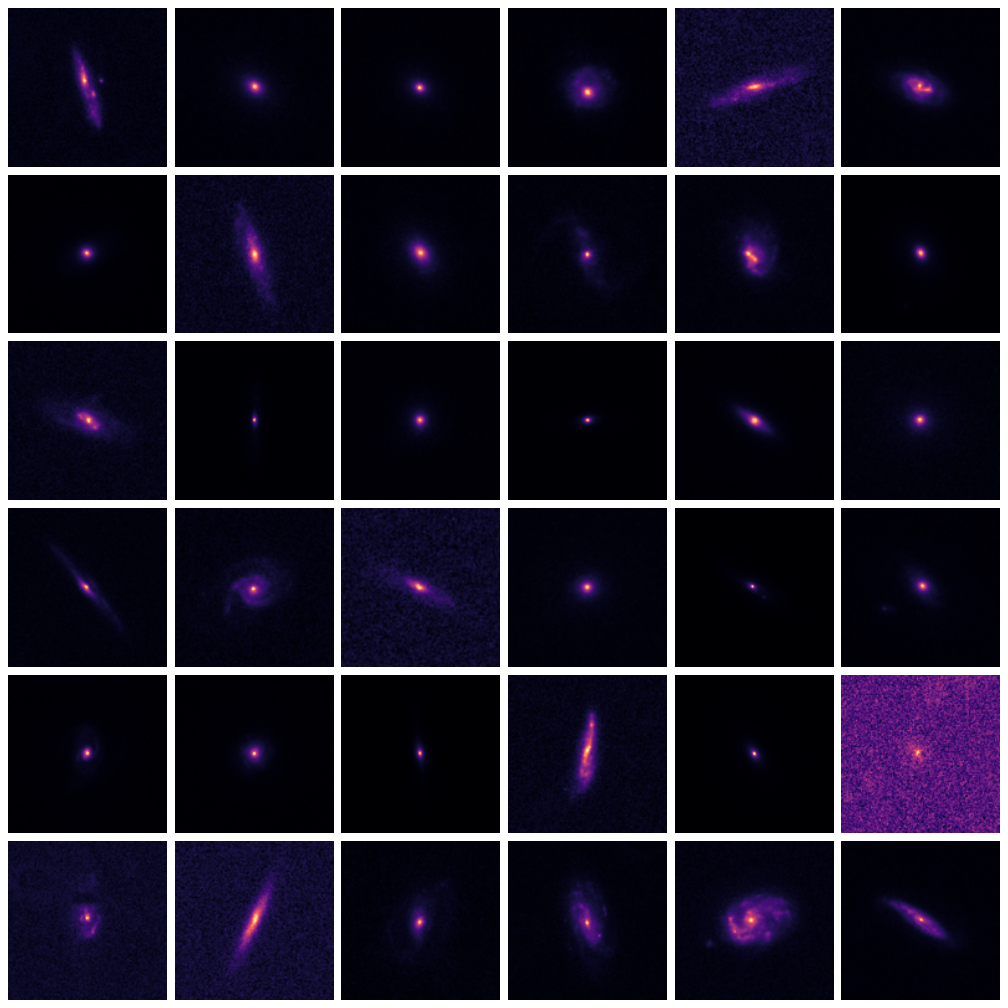

In [87]:
# Let's look at some data examples, you should see some clean galaxy images.
from mpl_toolkits.axes_grid1 import ImageGrid

fig = plt.figure(figsize=(16., 16.))
fig.patch.set_facecolor('white')
grid = ImageGrid(fig, 111, nrows_ncols=(6, 6),axes_pad=0.1,)
for ax, im in zip(grid, x[np.random.randint(len(x), size=36)]):
    ax.imshow(im, cmap='magma')
    ax.axis('off')
plt.show()
plt.close()

## Training routine
<figure>
    <img src="./figures/training-algorithm.png" alt="G. Louppe" width="400">
    <figcaption>Training algorithm </figcaption>
</figure>

In [9]:
def train(
    train_dataset, batch_size: int=16, num_time_steps: int=1000, num_epochs: int=15, save_patience: int=10,
    seed: int=-1, ema_decay: float=0.9999,  lr=2e-5, checkpoint_path: str=None,input_dim: int=32,
    unet_Channels: List=[64, 128, 256, 512, 512, 384],
    unet_Attentions: List = [False, True, False, False, False, True],
    unet_Upscales: List = [False, False, False, True, True, True],
    unet_num_groups: List = 32,
    unet_dropout_prob: List = 0.1,
    unet_num_heads: List = 8,
    unet_input_channels: List = 1,
    unet_output_channels: List = 1,
         ):
    
    set_seed(random.randint(0, 2**32-1)) if seed == -1 else set_seed(seed)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=4)
    
    # define scheduler
    scheduler = DDPM_Scheduler(num_time_steps=num_time_steps)
    
    # define models
    model = UNET(
            unet_Channels,
            unet_Attentions,
            unet_Upscales,
            unet_num_groups,
            unet_dropout_prob,
            unet_num_heads,
            unet_input_channels,
            unet_output_channels,
    ).cuda()
    # exponential moving average (ema)
    # When training a model, it is often beneficial to maintain moving averages of the trained parameters. 
    # Evaluations that use averaged parameters sometimes produce significantly better results than the final trained values.
    ema = ModelEmaV3(model, decay=ema_decay)
    
    # define optmizer
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    # load checkpoint if present
    if os.path.exists(checkpoint_path):
        print('Loading previous checkpoint')
        checkpoint = torch.load(checkpoint_path)
        model.load_state_dict(checkpoint['weights'])
        ema.load_state_dict(checkpoint['ema'])
        optimizer.load_state_dict(checkpoint['optimizer'])

    # define loss
    criterion = nn.MSELoss(reduction='mean')

    # start the training
    for i in range(num_epochs):
        total_loss = 0
        for bidx, x in enumerate(tqdm(train_loader, desc=f"Epoch {i+1}/{num_epochs}")):
            x = x.cuda()
            x = F.pad(x, (2,2,2,2))
            
            # FORWARD PROCESS
            # pick a random time step (t)
            t = torch.randint(0,num_time_steps,(batch_size,))
            # generate noise (e)
            e = torch.randn_like(x, requires_grad=False)
            # define the scheduler at time t (alpha_t)
            a = scheduler.alpha[t].view(batch_size,1,1,1).cuda()
            # update x: x(0) --> x(t)
            x = (torch.sqrt(a)*x) + (torch.sqrt(1-a)*e)

            # NOISE MATCHING
            output = model(x, t)
            optimizer.zero_grad()
            loss = criterion(output, e)
            total_loss += loss.item()
            loss.backward()
            optimizer.step()
            ema.update(model)
        print(f'Epoch {i+1} | Loss {total_loss / (60000/batch_size):.5f}')
        torch.cuda.empty_cache()

        if (not i%save_patience) or (i==(num_epochs-1)):
            print("Save checkpoint %i"%(i))
            # save model at the end of each epoch
            checkpoint = {
                'weights': model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'ema': ema.state_dict()
            }
            torch.save(checkpoint, checkpoint_path+'_%i'%(i))

In [73]:
# define data loader
N_train = 4000
N_test = 2000
data_path='./galaxy/cosmos_128.npy'
input_dim=64 # crop image for computational reasons, see npy_loader()

dataset = torch.utils.data.TensorDataset(npy_loader(data_path, input_dim))
train_dataset = dataset[:N_train, :]
test_dataset  = dataset[N_train:N_train+N_test, :]

In [13]:
# define hyper parameters
batch_size     = # ADD!!!
num_time_steps = # ADD!!!
num_epochs     = 2
seed           = -1
ema_decay      = 0.9999
lr             = # ADD!!!

# U-net architecture
unet_Channels = # ADD!!! 
unet_Attentions = # ADD!!!
unet_Upscales = # ADD!!!
unet_num_groups = # ADD!!!
unet_dropout_prob = 0.1
unet_num_heads = 8
unet_input_channels = 1
unet_output_channels = 1

train(train_dataset[0],
        batch_size=batch_size,
        num_time_steps=num_time_steps,
        num_epochs=num_epochs,
        seed=seed,
        ema_decay=ema_decay,
        lr=lr,
        input_dim=input_dim,
        checkpoint_path='checkpoints/ddpm_checkpoint_centercrop64',
        
        unet_Channels = unet_Channels,
        unet_Attentions = unet_Attentions,
        unet_Upscales = unet_Upscales,
        unet_num_groups = unet_num_groups,
        unet_dropout_prob = unet_dropout_prob,
        unet_num_heads = unet_num_heads,
        unet_input_channels = unet_input_channels,
        unet_output_channels = unet_output_channels,
)

Epoch 1/2:   0%|          | 0/194 [00:00<?, ?it/s]

Epoch 1 | Loss 0.00020


Epoch 2/2:   0%|          | 0/194 [00:00<?, ?it/s]

Epoch 2 | Loss 0.00019


## Generating new samples

<figure>
    <img src="./figures/sampling-algorithm.png" alt="G. Louppe" width="400">
    <figcaption>Sampling algorithm </figcaption>
</figure>

In [2]:
def generate(
        N,
        output_path: str=None,
        plot_images: bool=False,
        checkpoint_path: str=None,
        num_time_steps: int=1000,
        ema_decay: float=0.9999,
        input_dim: int=32,
        unet_Channels: List=[64, 128, 256, 512, 512, 384],
        unet_Attentions: List=[False, True, False, False, False, True],
        unet_Upscales: List=[False, False, False, True, True, True],
        unet_num_groups: List=32,
        unet_dropout_prob: List=0.1,
        unet_num_heads: List=8,
        unet_input_channels: List = 1,
        unet_output_channels: List = 1,
             ):
    '''
    Generate N new images and save them in .npy file if declared in output_path
    '''
    checkpoint = torch.load(checkpoint_path)
    model = UNET(
        unet_Channels,
        unet_Attentions,
        unet_Upscales,
        unet_num_groups,
        unet_dropout_prob,
        unet_num_heads,
        unet_input_channels,
        unet_output_channels,
    ).cuda()
    model.load_state_dict(checkpoint['weights'])
    ema = ModelEmaV3(model, decay=ema_decay)
    ema.load_state_dict(checkpoint['ema'])
    scheduler = DDPM_Scheduler(num_time_steps=num_time_steps)
    images = []

    with torch.no_grad():
        model = ema.module.eval()
        for i in range(N):
            z = torch.randn(1, 1, input_dim, input_dim)
            for t in reversed(range(1, num_time_steps)):
                t = [t]
                temp = (scheduler.beta[t]/( (torch.sqrt(1-scheduler.alpha[t]))*(torch.sqrt(1-scheduler.beta[t])) ))
                z = (1/(torch.sqrt(1-scheduler.beta[t])))*z - (temp*model(z.cuda(),t).cpu())
                e = torch.randn(1, 1, input_dim, input_dim)
                z = z + (e*torch.sqrt(scheduler.beta[t]))
            temp = scheduler.beta[0]/( (torch.sqrt(1-scheduler.alpha[0]))*(torch.sqrt(1-scheduler.beta[0])) )
            x = (1/(torch.sqrt(1-scheduler.beta[0])))*z - (temp*model(z.cuda(),[0]).cpu())
            images.append(x)
            if plot_images:
                x = rearrange(x.squeeze(0), 'c h w -> h w c').detach()
                x = x.numpy()
                fig = plt.figure(figsize=(8, 6))
                fig.patch.set_facecolor('white')
                plt.imshow(x, cmap='magma')
                plt.show()
                plt.close()
    images = torch.concat(images, dim=0)
    if output_path !=None:
        save_path= Path(output_path)
        os.makedirs(str(save_path.parent), exist_ok=True)
        if os.path.exists(output_path):
            print("Load previous samples")
            images_old = torch.from_numpy(np.load(output_path))
            print("number of previous generated samples: ", images_old.shape[0])
            images = torch.concat([images_old, images], dim=0)
            print("number of total generated samples: ", images.shape[0])
        np.save(save_path, images.numpy())
    return images

def display_reverse(images: List):
    fig, axes = plt.subplots(1, 10, figsize=(10,1))
    fig.patch.set_facecolor('white')
    for i, ax in enumerate(axes.flat):
        x = images[i].squeeze(0)
        x = rearrange(x, 'c h w -> h w c')
        x = x.numpy()
        ax.imshow(x, cmap='magma')
        ax.axis('off')
    plt.show()
    plt.close()
    
def plot_inference(
    N: int=10,
    checkpoint_path: str=None,
    num_time_steps: int=1000,
    ema_decay: float=0.9999, 
    input_dim: int=32,
    unet_Channels: List=[64, 128, 256, 512, 512, 384], 
    unet_Attentions: List = [False, True, False, False, False, True],
    unet_Upscales: List = [False, False, False, True, True, True],
    unet_num_groups: List = 32,
    unet_dropout_prob: List = 0.1,
    unet_num_heads: List = 8,
    unet_input_channels: List = 1,
    unet_output_channels: List = 1,
             ):
    checkpoint = torch.load(checkpoint_path)
    model = UNET(
        unet_Channels,
            unet_Attentions,
            unet_Upscales,
            unet_num_groups,
            unet_dropout_prob,
            unet_num_heads,
            unet_input_channels,
            unet_output_channels,
    ).cuda()
    model.load_state_dict(checkpoint['weights'])
    ema = ModelEmaV3(model, decay=ema_decay)
    ema.load_state_dict(checkpoint['ema'])
    scheduler = DDPM_Scheduler(num_time_steps=num_time_steps)
    times = [0,15,50,100,200,300,400,550,700,999]
    images = []

    with torch.no_grad():
        model = ema.module.eval()
        for i in range(N):
            z = torch.randn(1, 1, input_dim, input_dim)
            for t in reversed(range(1, num_time_steps)):
                t = [t]
                temp = (scheduler.beta[t]/( (torch.sqrt(1-scheduler.alpha[t]))*(torch.sqrt(1-scheduler.beta[t])) ))
                z = (1/(torch.sqrt(1-scheduler.beta[t])))*z - (temp*model(z.cuda(),t).cpu())
                if t[0] in times:
                    images.append(z)
                e = torch.randn(1, 1, input_dim, input_dim)
                z = z + (e*torch.sqrt(scheduler.beta[t]))
            temp = scheduler.beta[0]/( (torch.sqrt(1-scheduler.alpha[0]))*(torch.sqrt(1-scheduler.beta[0])) )
            x = (1/(torch.sqrt(1-scheduler.beta[0])))*z - (temp*model(z.cuda(),[0]).cpu())

            images.append(x)
            x = rearrange(x.squeeze(0), 'c h w -> h w c').detach()
            x = x.numpy()
            fig = plt.figure(figsize=(8, 6))
            fig.patch.set_facecolor('white')
            plt.imshow(x, cmap='magma')
            plt.show()
            plt.close()
            display_reverse(images)
            images = []

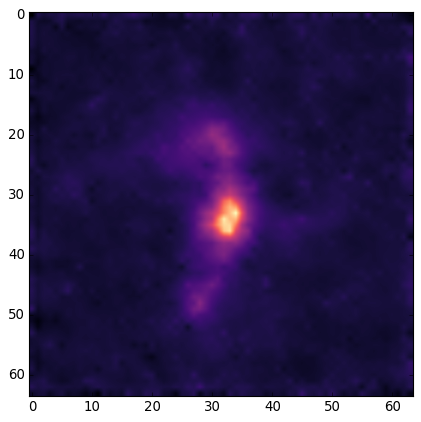

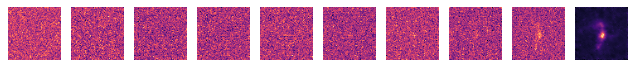

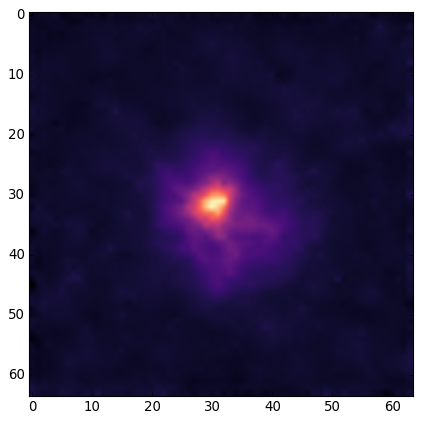

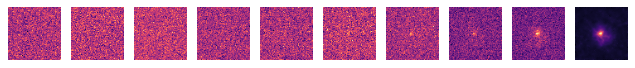

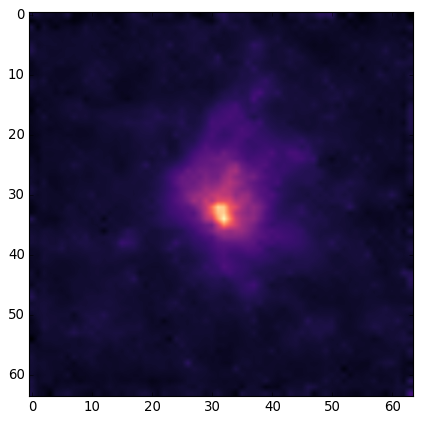

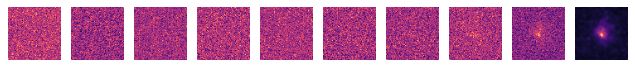

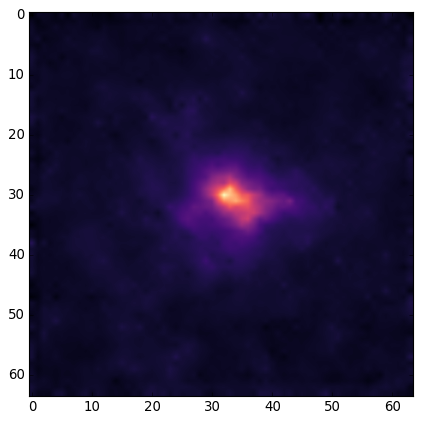

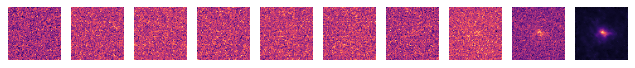

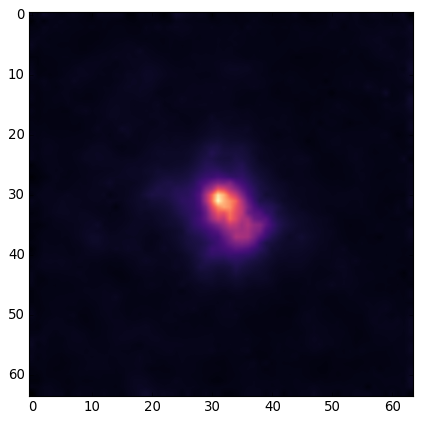

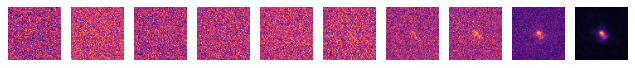

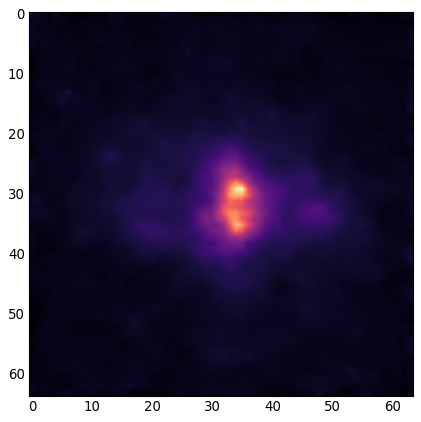

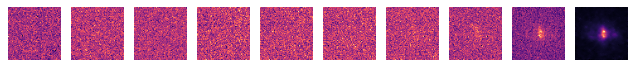

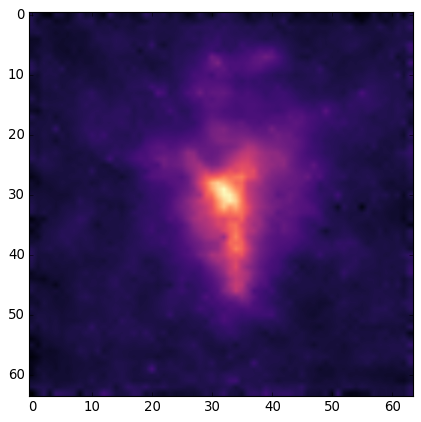

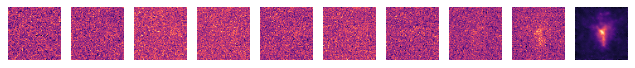

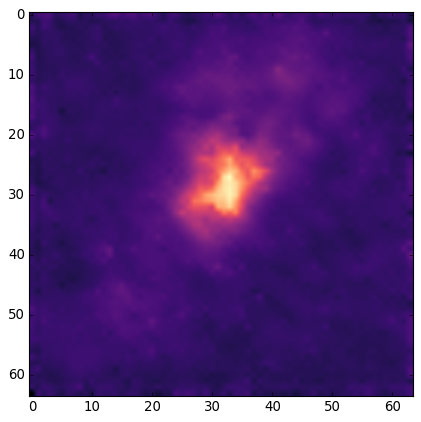

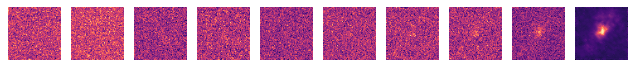

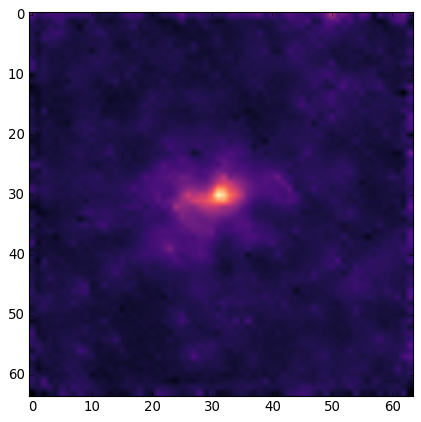

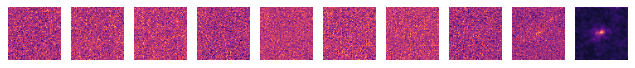

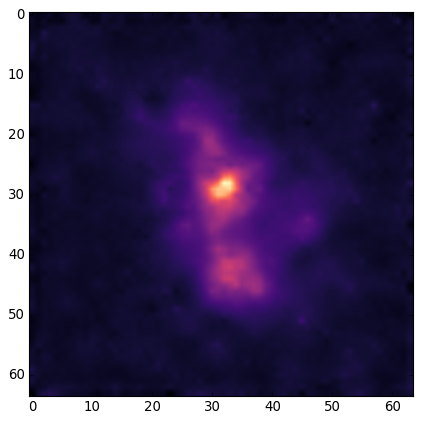

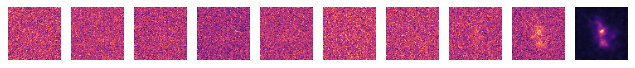

In [92]:
#epoch 80
plot_inference(checkpoint_path='checkpoints/ddpm_checkpoint_centercrop64',
          input_dim=64,
         unet_Channels = [128, 256, 512, 512],
            unet_Attentions = [False, True, False, True],
            unet_Upscales = [False, False, True, True],
            unet_num_groups = 64,
            unet_dropout_prob = 0.1,
            unet_num_heads = 8,
            unet_input_channels = 1,
            unet_output_channels = 1,
         )

### QUEST
Can you modify the code to handle the full size image (128x128 pixels)?

_________________________
# Part 2: How to quantify the goodness of a generative model??

To quantify the goodness of the generator one can perform several two sample tests based on training a binary classifier between two samples, one coming from the original generator the other coming from the diffusion model. 

Before starting this sesssion, have a look at **tutorial 3** for an introduction to two-smaple testing. 


## Generate test sample
Let's start by generating new images to compare with the original ones

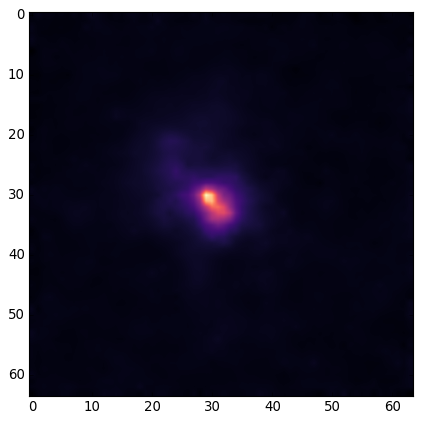

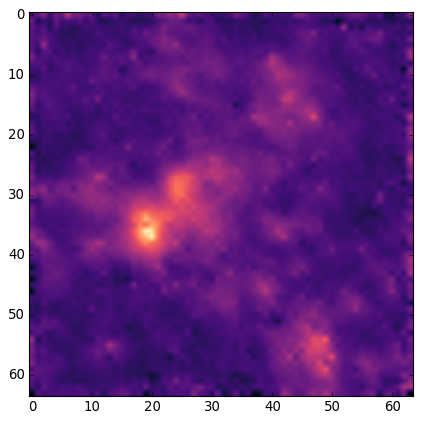

Load previous samples
number of previous generated samples:  214
number of total generated samples:  216


In [90]:
images = generate(
        N=2,
        output_path='./generation/ddpm_generation_centercrop64.npy',
        plot_images=True,
        checkpoint_path='checkpoints/ddpm_checkpoint_centercrop64',
        input_dim=64,
        unet_Channels=[128, 256, 512, 512],
        unet_Attentions=[False, True, False, True],
        unet_Upscales=[False, False, True, True],
        unet_num_groups=64,
        unet_dropout_prob=0.1,
        unet_num_heads=8,
        unet_input_channels=1,
        unet_output_channels=1,
             )

In [52]:
images = generate(
        N=100,
        output_path='./generation/ddpm_generation_centercrop64.npy',
        plot_images=False,
        checkpoint_path='checkpoints/ddpm_checkpoint_centercrop64',
        input_dim=64,
        unet_Channels=[128, 256, 512, 512],
        unet_Attentions=[False, True, False, True],
        unet_Upscales=[False, False, True, True],
        unet_num_groups=64,
        unet_dropout_prob=0.1,
        unet_num_heads=8,
        unet_input_channels=1,
        unet_output_channels=1,
             )

Load previous samples
number of previous generated samples:  110
number of total generated samples:  210


### Load data

In [102]:
N_train = 2000
N_test = 2000
data_path='./galaxy/cosmos_128.npy'
input_dim=64

# original data
dataset = torch.utils.data.TensorDataset(npy_loader(data_path, input_dim))
train_dataset = dataset[:N_train, :]
test_dataset  = dataset[N_train:N_train+N_test, :]
# generated data
gen_dataset = torch.from_numpy(np.load('./generation/ddpm_generation_centercrop64.npy'))

torch.Size([6210, 1, 64, 64])


In [152]:
sample_1 = # ADD!!!
sample_0 =  # ADD!!!
N_0, N_1 =  # ADD!!!,  # ADD!!!

relative_weight =  # ADD!!!
print('relative weight: ', relative_weight)
weight_1  = torch.ones((N_1,1))
weight_0  = torch.ones((N_0,1))*relative_weight

data_tr = torch.concat([sample_0, sample_1])
weight_tr = torch.concat([weight_0, weight_1])
target_0 = torch.zeros((N_0,1))
target_1 = torch.ones((N_1,1))
target_tr = torch.concat([target_0, target_1])

train_loader = DataLoader(list(zip(data_tr, target_tr, weight_tr)), batch_size=N_0+N_1, shuffle=True, drop_last=True, num_workers=4)

relative weight:  0.108


## Design a binary classifier model
Let's define a CNN architecture for the binary classifier


In [153]:
class classifier(nn.Module):
    def __init__(self, 
                 # ADD!!!
               ):
        super(classifier, self).__init__()
         # ADD!!!
        
    def forward(self, x):
         # ADD!!!
        return x

def weighted_binary_crossentropy(output, target, weight):
    y = target[:, 0]
    w = weight[:, 0]
    f = output[:, 0]
    return -1*torch.mean(y*w*torch.log(f) + (1-y)*w*torch.log(1-f))

def inv_sigmoid(p):
    return torch.log(p/(1-p)) 

def likelihood_ratio(true, pred, weight):
    f   = pred[:, 0]
    y   = true[:, 0]
    w = weight[:, 0]
    return 2*torch.sum((1-y)*w*(1-torch.exp(f)) + y*w*f) 

def balanced_accuracy(true, pred):
    y = true[:, 0]
    f = pred[:, 0]
    if torch.sum(1-y)>0 and torch.sum(y)>0:
        return 0.5*torch.sum((1-y)*(f<0.5))/torch.sum(1-y) + 0.5*torch.sum(y*(f>=0.5))/torch.sum(y)
    elif torch.sum(1-y)==0 and torch.sum(y)>0:
        return torch.sum(y*(f>=0.5))/torch.sum(y)
    elif torch.sum(1-y)>0 and torch.sum(y)==0:
        return torch.sum((1-y)*(f<0.5))/torch.sum(1-y)
    else:
        return torch.tensor([0])

In [147]:
# initialize model
model = classifier()
print(model)
model.cuda()

# initialize optimizer
optimizer =  # ADD!!!

# initilie loss
criterion =  # ADD!!!

CNN_classifier(
  (hidden_cnn): ModuleList(
    (0): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), padding=(1, 1))
    (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), padding=(1, 1))
    (2): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1), padding=(1, 1))
  )
  (transit): Linear(in_features=72, out_features=16, bias=True)
  (hidden_dnn): ModuleList(
    (0): Linear(in_features=16, out_features=4, bias=True)
    (1): Linear(in_features=4, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.1, inplace=False)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (LeakyReLU): LeakyReLU(negative_slope=0.2)
  (sigmoid): Sigmoid()
)


### Train the binary classifier

In [148]:
loss_history = []

In [149]:
n_epochs = 200 # you may increase this number to train a final model

for epoch in range(1, n_epochs+1):
    # keep track of training and validation loss
    train_loss = 0.0
    model.train()
    for idx, (data, target, weight) in enumerate(train_loader):
        # move tensors to GPU if CUDA is available
        target, data, weight = target.float(), data.float(), weight.float()
        data, target, weight = data.cuda(), target.cuda(), weight.cuda()
        data, target = data.cuda(), target.cuda()
        data = rearrange(data, 'b c h w -> b h w c')
         # ADD!!!
         # ...
         # ADD!!!
    loss_history.append(train_loss)
    if not epoch%10:
        print('Epoch: {} \tTraining Loss: {:.6f}'  .format(epoch, train_loss))
    
    # save model if validation loss has decreased
    torch.save(model.state_dict(), './some-name-you-like.pt')

Epoch: 10 	Training Loss: 0.135802
Epoch: 20 	Training Loss: 0.135601
Epoch: 30 	Training Loss: 0.135195
Epoch: 40 	Training Loss: 0.135008
Epoch: 50 	Training Loss: 0.134884
Epoch: 60 	Training Loss: 0.133976
Epoch: 70 	Training Loss: 0.133384
Epoch: 80 	Training Loss: 0.132500
Epoch: 90 	Training Loss: 0.131159
Epoch: 100 	Training Loss: 0.130443
Epoch: 110 	Training Loss: 0.129107
Epoch: 120 	Training Loss: 0.127470
Epoch: 130 	Training Loss: 0.124962
Epoch: 140 	Training Loss: 0.121429
Epoch: 150 	Training Loss: 0.117363
Epoch: 160 	Training Loss: 0.113577
Epoch: 170 	Training Loss: 0.111194
Epoch: 180 	Training Loss: 0.106925
Epoch: 190 	Training Loss: 0.104289
Epoch: 200 	Training Loss: 0.103157


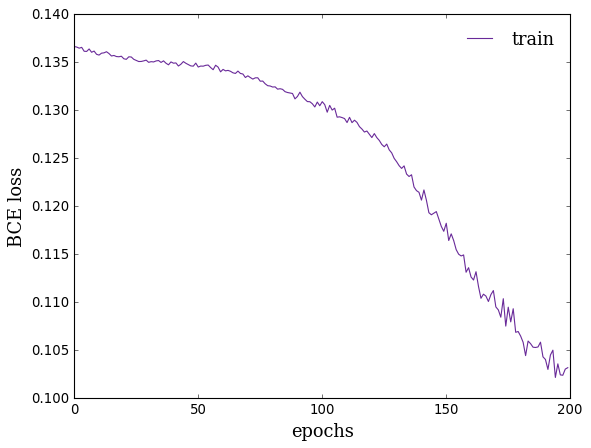

In [150]:
fig = plt.figure(figsize=(8, 6))
fig.patch.set_facecolor('white')
plt.plot(loss_history, label='train', color='#692A99')#'#EA4F88')
plt.ylabel('BCE loss', fontname='serif', fontsize=16)
plt.xlabel('epochs', fontname='serif', fontsize=16)
plt.legend(prop=font, loc='best', frameon=False)
#plt.yscale('log')
plt.show() 

### Evalutate classification performance

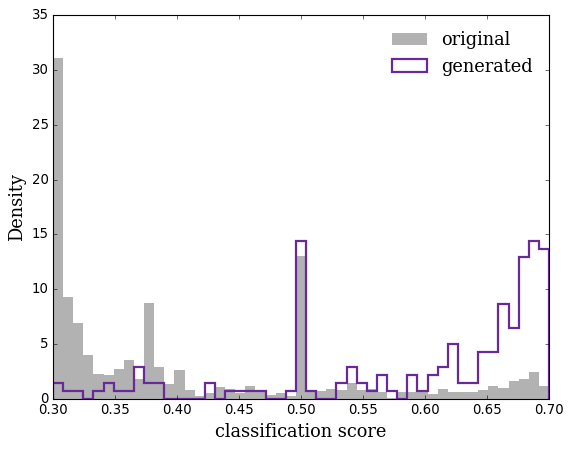

In [151]:
with torch.no_grad():
    fig = plt.figure(figsize=(8, 6))
    fig.patch.set_facecolor('white')
    output = model(data)[:, 0:1]
    bins = np.linspace(0.3,0.7,50)
    plt.hist(output[target[:, 0]==0].cpu().numpy(), bins=bins, density=True, color='black', ec='none', 
             alpha=0.3, label='original')
    plt.hist(output[target[:, 0]==1].cpu().numpy(), bins=bins, density=True, color='#692A99', 
             label='generated', histtype='step', lw=2)
    plt.xlabel("classification score", fontname='serif', fontsize=16)
    plt.ylabel("Density", fontname='serif', fontsize=16)
    #plt.yscale('log')
    plt.legend(prop=font, loc='best', frameon=False)
    plt.show()


In [154]:
output = model(data)
bacc_obs = # ADD !!!
logr = inv_sigmoid(model(data))#torch.log(model(data)[:, 1:2]/model(data)[:, 0:1])#output[:, 1:2]
lrt_obs =  # ADD!!!
print("BACC: ", bacc_obs)
print("LRT: ", lrt_obs)

BACC:  0.7922592163085938
LRT:  300.3842468261719


### metrics calibration

In [ ]:
# ADD!!!

### QUEST
Is your model a good generative model? How could it be improved?